In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
proj_path = Path('.').resolve()
sys.path.append(str(proj_path))

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import json
from tqdm import tqdm
import numpy as np
import pandas as pd
from collections import defaultdict
from dotenv import load_dotenv, find_dotenv


_ = load_dotenv(find_dotenv())

from src.db_utils import get_schema_str, get_data_dict
from src.pymodels import (
    DatabaseModel, 
    SpiderSample, 
    BirdSample, 
    BODescription,
    SQLResponse
)
from src.prompts import Prompts
from src.database import SqliteDatabase
from src.data_preprocess import (
    load_raw_data,
    process_all_tables,
    filter_samples_by_count_spider_bird,
    process_samples_bird,
    split_train_dev_test,
    save_samples_spider_bird,
    load_samples_spider_bird,
)

from src.parsing_sql import Schema, extract_all
from src.eval_utils import get_complexity, result_eq, check_if_exists_orderby
from run_bo_sql import get_vector_store
from copy import deepcopy


In [216]:
# bird_path = proj_path / 'data' / 'bird'
# tables, train_data, dev_data = load_raw_data(bird_path, load_test=False)

# with (proj_path / 'data' / 'bird_description.json').open() as f:
#     all_descriptions = json.load(f)

# tables = process_all_tables(tables, descriptions=all_descriptions)
# train_samples = load_samples_spider_bird(proj_path / 'data' / '{ds}_train.json')
# dev_samples = load_samples_spider_bird(proj_path / 'data' / '{ds}_dev.json')
# test_samples = load_samples_spider_bird(proj_path / 'data' / '{ds}_test.json')
# bo_path = proj_path / 'experiments' / ds / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json'
# with bo_path.open() as f:
#     all_bos = json.load(f)

In [ ]:
# question and BA similarity to the question

In [3]:
from run_bo_sql import _get_categories, _format_interval, _get_categories_with_same_name

def merge(df_base, df_bo):
    df = pd.merge(
        left=df_bo,
        right=df_base,
        how='inner',
        on=['db_id', 'sample_id', 'gold_complexity'],
        suffixes=('_bo', '_base')
    )
    return df

def get_merits(df: pd.DataFrame, group_column=None): 
    execution_improvement = df.groupby(group_column)[['exec_result_base', 'exec_result_bo']].mean().diff(axis=1)['exec_result_bo'].rename('execution_improvement')
    merit_structural = df.groupby(group_column)[['structural_score_base', 'structural_score_bo']].mean().diff(axis=1)['structural_score_bo'].rename('merit_structural')
    merit_semantic = df.groupby(group_column)[['semantic_score_base', 'semantic_score_bo']].mean().diff(axis=1)['semantic_score_bo'].rename('merit_semantic')
    merit = df.groupby(group_column)[['f1_score_base', 'f1_score_bo']].mean().diff(axis=1)['f1_score_bo'].rename('merit')

    return {
        'execution_improvement': execution_improvement,
        'merit_structural': merit_structural,
        'merit_semantic': merit_semantic,
        'merit': merit
    }

In [ ]:
from run_evaluation import get_target_parsed_sql
from src.eval_utils import get_complexity
import pickle
ds = 'bird'
task = 'zero_shot_hint'
typ = 'test'
scenario = 2

description_file = f'{ds}_description.json' if ds == 'bird' else f'description.json' 
experiment_folder = proj_path / 'experiments' / ds
prediction_path = experiment_folder / 'predictions' / task
eval_path = experiment_folder / 'evals' / task

tables, *_ = load_raw_data(proj_path / 'data' / ds, load_test=False)
with (proj_path / 'data' / description_file).open() as f:
    all_descriptions = json.load(f)
tables = process_all_tables(tables, descriptions=all_descriptions)

filter_db_ids = ['bike_share_1', 'language_corpus', 'donor', 'menu', 'movie_platform', 'talkingdata', 'authors', 'image_and_language']
file_post_fix = f'{ds}_{typ}' if scenario < 0 else f'{ds}_{typ}_{scenario}'
split_k = 2 if scenario < 0 else 3

train_samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_train.json')
dev_samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_dev.json')
test_samples = load_samples_spider_bird(proj_path / 'data' / f'{ds}_test.json')
bo_path = proj_path / 'experiments' / ds / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json'
with bo_path.open() as f:
    all_bos = json.load(f)

if typ == 'test':
    samples = test_samples
elif typ == 'dev':
    samples = dev_samples
else:
    samples = train_samples

# recalculate gold complexity

final_file = f'final_{file_post_fix}.json'
with open(prediction_path / final_file, 'r') as f:
    preds = json.load(f)
# filter samples with db_id
res_db_ids = {r['db_id'] for r in preds}
# filter db_ids 
res_db_ids = res_db_ids - set(filter_db_ids)
print(f'Found {len(res_db_ids)} db_ids')
preds = [p for p in preds if p['db_id'] in res_db_ids]
samples = [s for s in samples if s.db_id in res_db_ids]

# get target_parsed_sql
file_name = f'{file_post_fix}_parsed.pkl'  
if not (eval_path / file_name).exists():
    target_parsed, _ = get_target_parsed_sql(samples, tables)
    with open(eval_path / file_name, 'wb') as f:
        pickle.dump(target_parsed, f)

with open(eval_path / file_name, 'rb') as f:
    target_parsed = pickle.load(f)

# for parsed in target_parsed:
#     parsed['gold_complexity'] = get_complexity(parsed['sql'])
target_complexities = []
for db_id, parsed in tqdm(target_parsed.items(), total=len(target_parsed)):
    for sample_id, x in parsed.items():
        target_complexities.append({
            'db_id': db_id,
            'sample_id': sample_id,
            'gold_complexity': get_complexity(x)
        })

df_com = pd.DataFrame(target_complexities)

Found 71 db_ids


100%|██████████| 71/71 [00:00<00:00, 6040.36it/s]


In [47]:
# load test data

df_base = pd.read_csv(experiment_folder / 'evals' / 'zero_shot' / f'{ds}_test.csv')
df_0 = pd.read_csv(eval_path / f'{ds}_{typ}_0.csv')
df_1 = pd.read_csv(eval_path / f'{ds}_{typ}_1.csv')
df_2 = pd.read_csv(eval_path / f'{ds}_{typ}_2.csv')
df_3 = pd.read_csv(eval_path / f'{ds}_{typ}_3.csv')
common_ids = set(df_base['sample_id']) & set(df_0['sample_id']) & set(df_1['sample_id']) & set(df_2['sample_id']) & set(df_3['sample_id'])

df_base = df_base[df_base['sample_id'].isin(common_ids)]
df_cates = df_base.groupby('db_id')['gold_complexity'].apply(_get_categories_with_same_name).rename('category')
df_base = pd.merge(df_base, df_cates.reset_index('db_id', drop=True), left_index=True, right_index=True)
df_0 = merge(df_base, df_0[df_0['sample_id'].isin(common_ids)])
df_1 = merge(df_base, df_1[df_1['sample_id'].isin(common_ids)])
df_2 = merge(df_base, df_2[df_2['sample_id'].isin(common_ids)])
df_3 = merge(df_base, df_3[df_3['sample_id'].isin(common_ids)])

df_0['r_bool'] = df_0['retrieved'].apply(lambda x: len(eval(x))>0)
df_1['r_bool'] = df_1['retrieved'].apply(lambda x: len(eval(x))>0)
df_2['r_bool'] = df_2['retrieved'].apply(lambda x: len(eval(x))>0)
df_3['r_bool'] = df_3['retrieved'].apply(lambda x: len(eval(x))>0)

merits_0 = get_merits(df_0, group_column=['db_id'])
merits_1 = get_merits(df_1, group_column=['db_id'])
merits_2 = get_merits(df_2, group_column=['db_id'])
merits_3 = get_merits(df_3, group_column=['db_id'])

# train_samples = [s for s in train_samples if s.sample_id in common_ids]
# dev_samples = [s for s in dev_samples if s.sample_id in common_ids]
test_samples = [s for s in test_samples if s.sample_id in common_ids]

In [26]:
for key in ['exec_result', 'f1_score', 'structural_score', 'semantic_score']:
    df_temp = df_base.groupby('db_id')[key].mean().describe()
    print(f'== {key} ==')
    print(f"{df_temp['mean']*100:.2f} \% ± {df_temp['std']*100:.2f}")

== exec_result ==
34.48 \% ± 18.30
== f1_score ==
61.71 \% ± 9.55
== structural_score ==
60.48 \% ± 10.24
== semantic_score ==
66.40 \% ± 8.90


In [27]:
merits_2['execution_improvement'].sort_values(ascending=False).head(10)

db_id
movie                 0.285714
computer_student      0.200000
sales                 0.200000
california_schools    0.187500
coinmarketcap         0.181818
legislator            0.157895
mondial_geo           0.152542
card_games            0.142857
superstore            0.125000
trains                0.125000
Name: execution_improvement, dtype: float64

In [28]:
merits_2['merit'].sort_values(ascending=False).head(10)

db_id
movie                   0.315152
mental_health_survey    0.182483
codebase_community      0.182370
coinmarketcap           0.169445
legislator              0.165459
retail_complains        0.153909
genes                   0.146007
citeseer                0.144676
social_media            0.128691
mondial_geo             0.127752
Name: merit, dtype: float64

In [29]:
# examples
df_temp = df_2.loc[(df_2['exec_result_bo'] - df_2['exec_result_base']) == 0]
df_temp.iloc[(df_temp['f1_score_bo'] - df_temp['f1_score_base']).rank(ascending=True).argsort()]

,sample_id,db_id,retrieved,structural_score_bo,semantic_score_bo,f1_score_bo,exec_result_bo,gold_complexity,structural_score_base,semantic_score_base,f1_score_base,exec_result_base,category,r_bool
301,1535,synthea,[1363],0.2756,0.1831,0.220023,0,10,1.0000,1.0000,1.0000,0,1,True
815,7839,world,[7850],0.1931,0.3333,0.244530,1,8,1.0000,1.0000,1.0000,1,1,True
123,3345,video_games,[3320],0.2536,0.3670,0.299939,0,10,1.0000,1.0000,1.0000,0,3,True
837,4825,legislator,[4774],0.3333,0.2985,0.314942,0,6,1.0000,1.0000,1.0000,0,0,True
278,2602,regional_sales,[2661],0.3571,0.6236,0.454140,0,5,0.1363,0.1421,1.0596,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,841,social_media,[791],1.0000,1.0000,1.000000,1,8,0.1931,0.1931,0.1931,1,0,True
702,248,retail_complains,[263],0.8000,0.9253,0.858100,0,12,0.0000,0.0000,0.0000,0,4,True
971,746,movie,[754],0.8990,0.9657,0.931157,0,11,0.0000,0.0000,0.0000,0,4,True
11,2380,superstore,[2384],0.9250,0.9721,0.947965,0,9,0.0000,0.0000,0.0000,0,1,True


In [31]:
import sqlglot
from pprint import pprint

test_preds = []
with open(proj_path / 'experiments' / ds / 'predictions' / 'zero_shot' / f'final_{ds}_test.jsonl') as f:
    for line in f:
        sample = json.loads(line)
        test_preds.append(sample)

test_preds_new = []
with open(proj_path / 'experiments' / ds / 'predictions' / 'zero_shot_hint' / f'final_{ds}_test_2.json') as f:
    test_preds_new = json.load(f)

sample_id = 6260
bo_id = 6254

# find error sql
# for pred in 
print()
for sample in test_samples:
    if sample.sample_id == sample_id:
        db_id = sample.db_id
        print(sample.db_id)
        print(sample.final.question)
        print(sqlglot.parse_one(sample.final.sql).sql(pretty=True))
        break

final_sample = sample
schema = Schema(tables[db_id].db_schema)

print('** original pred')
for sample in test_preds:
    if sample['sample_id'] == sample_id:
        print(sqlglot.parse_one(sample['pred_sql']).sql(pretty=True))
        break

print('** after bo')
for sample in test_preds_new:
    if sample['sample_id'] == sample_id:
        print(sqlglot.parse_one(sample['pred_sql']).sql(pretty=True))
        break


print()
for sample in all_bos[db_id]:
    if sample['sample_id'] == bo_id:
        pprint(sample['ba'])
        print(sqlglot.parse_one(sample['vt']).sql(pretty=True))
        print(sample['gold_complexity'])
        break


coinmarketcap
Name the coin and date of transactions with the greatest decline in percent change in 1 hour.
SELECT
  T1.name,
  T2.date
FROM coins AS T1
INNER JOIN historical AS T2
  ON T1.id = T2.coin_id
WHERE
  T2.percent_change_1h = (
    SELECT
      MIN(percent_change_1h)
    FROM historical
  )
** original pred
SELECT
  c.name,
  h.date
FROM historical AS h
JOIN coins AS c
  ON h.coin_id = c.id
ORDER BY
  h.percent_change_1h ASC
LIMIT 1
** after bo
SELECT
  coins.name,
  historical.date
FROM coins
INNER JOIN historical
  ON coins.id = historical.coin_id
WHERE
  historical.percent_change_1h = (
    SELECT
      MIN(percent_change_1h)
    FROM historical
  )

('The virtual table displays the names of coins along with their historical '
 "transaction dates and prices. It retrieves data from the 'coins' table and "
 "the 'historical' table, joining them based on the coin's unique identifier. "
 'The query specifically filters for the coin that has experienced the highest '
 'percent

In [32]:
output = extract_all(sample['vt'], schema)  # final_sample.final.sql  sample['vt']
args1 = [('sel', 'sel_asts'), ('cond_asts', 'op_types'), ('agg', 'agg_asts'), ('orderby', 'orderby_asts')]
args2 = ['distinct', 'limit', 'nested', 'table_asts']
total_complexity = []
for arg in args1:
    exists = all([output[arg[0]], output[arg[1]]])
    if exists:
        x = [len(output[arg[0]]), len(output[arg[1]])]
        complexity = np.sum(x)
        total_complexity.append(complexity)
        print(f'arg={arg[1]} complexity={complexity}')

for arg in args2:
    if output[arg]:
        if arg == 'nested':
            complexity = output[arg]
            print(f'arg={arg} complexity={complexity}')
        if arg == 'table_asts':
            complexity = len(output[arg])
            print(f'arg={arg} complexity={complexity}')
        if arg in ('limit', 'distinct') and output[arg]:
            complexity = int(output[arg])
            print(f'arg={arg} complexity={complexity}')
        total_complexity.append(complexity)

print(sum(total_complexity))

arg=sel_asts complexity=8
arg=op_types complexity=2
arg=nested complexity=2
arg=table_asts complexity=3
15


In [33]:
from src.eval_utils import get_complexity, get_partial_score
from src.parsing_sql import Schema, extract_all


with (proj_path / 'data' / 'bird_description.json').open() as f:
    all_descriptions = json.load(f)

bird_path = proj_path / 'data' / 'bird'
tables, train_data, dev_data = load_raw_data(bird_path, load_test=False)

tables = process_all_tables(tables, descriptions=all_descriptions)

In [34]:
import sqlglot
from pprint import pprint

test_preds = []
with open(proj_path / 'experiments' / ds / 'predictions' / 'zero_shot' / f'final_{ds}_test.jsonl') as f:
    for line in f:
        sample = json.loads(line)
        test_preds.append(sample)

test_preds_new = []
with open(proj_path / 'experiments' / ds / 'predictions' / 'zero_shot_hint' / f'final_{ds}_test_2.json') as f:
    test_preds_new = json.load(f)

sample_id = 4825 # 7839
bo_id = 4774 # 7850

# find error sql
# for pred in 
print()
for sample in test_samples:
    if sample.sample_id == sample_id:
        db_id = sample.db_id
        print(sample.db_id)
        print(sample.final.question)
        print(sqlglot.parse_one(sample.final.sql).sql(pretty=True))
        break

final_sample = sample
schema = Schema(tables[db_id].db_schema)

print('** original pred')
for sample in test_preds:
    if sample['sample_id'] == sample_id:
        print(sqlglot.parse_one(sample['pred_sql']).sql(pretty=True))
        break

print('** after bo')
for sample in test_preds_new:
    if sample['sample_id'] == sample_id:
        print(sqlglot.parse_one(sample['pred_sql']).sql(pretty=True))
        break


print()
for sample in all_bos[db_id]:
    if sample['sample_id'] == bo_id:
        print(sample['ba'])
        print(sqlglot.parse_one(sample['vt']).sql(pretty=True))
        print(sample['gold_complexity'])
        break


legislator
How many of the legislators are male?
SELECT
  COUNT(*)
FROM current
WHERE
  gender_bio = 'M'
** original pred
SELECT
  COUNT(*) AS male_legislators
FROM current
WHERE
  gender_bio = 'male'
** after bo
SELECT
  COUNT(CASE WHEN current.gender_bio = 'male' THEN current.bioguide_id ELSE NULL END) AS male_count
FROM current

The virtual table calculates the proportion of current legislators of a specific gender compared to historical legislators of the same gender. It counts the number of current legislators matching the specified gender and multiplies it by a numeric placeholder, then divides by the total count of historical legislators of that gender.
SELECT
  CAST(COUNT(
    CASE
      WHEN current.gender_bio = '[placeholder-type:string]'
      THEN current.bioguide_id
      ELSE NULL
    END
  ) AS FLOAT) * ARRAY(placeholder - type : numeric) / (
    SELECT
      COUNT(
        CASE
          WHEN historical.gender_bio = '[placeholder-type:string]'
          THEN historical

In [35]:
output = extract_all(final_sample.final.sql, schema)  # final_sample  sample['vt']
args1 = [('sel', 'sel_asts'), ('cond_asts', 'op_types'), ('agg', 'agg_asts'), ('orderby', 'orderby_asts')]
args2 = ['distinct', 'limit', 'nested', 'table_asts']
total_complexity = []
for arg in args1:
    exists = all([output[arg[0]], output[arg[1]]])
    if exists:
        x = [len(output[arg[0]]), len(output[arg[1]])]
        complexity = np.sum(x)
        total_complexity.append(complexity)
        print(f'arg={arg[1]} complexity={complexity}')

for arg in args2:
    if output[arg]:
        if arg == 'nested':
            complexity = output[arg]
            print(f'arg={arg} complexity={complexity}')
        if arg == 'table_asts':
            complexity = len(output[arg])
            print(f'arg={arg} complexity={complexity}')
        if arg in ('limit', 'distinct') and output[arg]:
            complexity = int(output[arg])
            print(f'arg={arg} complexity={complexity}')
        total_complexity.append(complexity)

print(sum(total_complexity))

arg=sel_asts complexity=2
arg=op_types complexity=2
arg=nested complexity=1
arg=table_asts complexity=1
6


In [327]:
from src.database import SqliteDatabase

typ = 'train'
db = SqliteDatabase(str(proj_path / 'data' / 'bird' / typ / f'{typ}_databases' / db_id / f'{db_id}.sqlite'))

In [330]:
db.execute("""
SELECT
COUNT(
CASE
WHEN current.gender_bio = 'M'
THEN current.bioguide_id
ELSE NULL
END) AS male_count
FROM current
""")

,male_count
0,432


In [331]:
db.execute("""
SELECT COUNT(*) FROM current WHERE gender_bio = 'M'
""")

,COUNT(*)
0,432


In [264]:
db.execute("""
SELECT
  coins.name,
  historical.date,
  historical.percent_change_1h
FROM coins
INNER JOIN historical
  ON coins.id = historical.coin_id
WHERE
  historical.percent_change_1h = (
    SELECT
      MIN(percent_change_1h)
    FROM historical
  )
""")

,name,date,percent_change_1h
0,Ethereum Movie Venture,2017-05-28,-100.0
1,ValueChain,2021-05-05,-100.0
2,DEMOS,2021-05-05,-100.0
3,FantasyGold,2021-06-04,-100.0
4,Hina Inu,2021-06-07,-100.0
5,Safetesla,2021-06-24,-100.0
6,FantasyGold,2021-07-01,-100.0
7,FantasyGold,2021-07-08,-100.0
8,Vanywhere,2021-07-08,-100.0
9,FantasyGold,2021-07-09,-100.0


In [36]:
exps = ['10 BOs', '15 BOs', '25 BOs', '25 BOs(Q-VT)']
for key in ['execution_improvement', 'merit_structural', 'merit_semantic', 'merit']:
    print(f'====================== {key} ======================')
    for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
        df_key = df_m[key].describe()#.reset_index().groupby('db_id')[key].describe().sort_values('mean', ascending=False)
        df_v = (df_m[key] > 0).value_counts()
        print(f'{exps[i]}')
        improved = df_m[key].loc[df_m[key] > 0].mean()
        improved_std = df_m[key].loc[df_m[key] > 0].std()
        unimproved = df_m[key].loc[df_m[key] <= 0].mean()
        unimproved_std = df_m[key].loc[df_m[key] <= 0].std()
        print(f' - Improved {df_v[True] / df_v.sum()*100:.2f} ({df_v[True]}/{df_v.sum()}) | +{improved*100:.2f} ({improved_std*100:.2f}) databases') 
        print(f' - Unimproved {df_v[False] / df_v.sum()*100:.2f} ({df_v[False]}/{df_v.sum()}) | {unimproved*100:.2f} ({unimproved_std*100:.2f}) databases')

====================== execution_improvement ======================
10 BOs
 - Improved 38.03 (27/71) | +9.22 (7.41) databases
 - Unimproved 61.97 (44/71) | -5.69 (7.23) databases
15 BOs
 - Improved 36.62 (26/71) | +10.14 (5.74) databases
 - Unimproved 63.38 (45/71) | -4.40 (5.59) databases
25 BOs
 - Improved 47.89 (34/71) | +9.87 (6.37) databases
 - Unimproved 52.11 (37/71) | -7.05 (7.19) databases
25 BOs(Q-VT)
 - Improved 49.30 (35/71) | +10.95 (7.80) databases
 - Unimproved 50.70 (36/71) | -3.88 (5.13) databases
====================== merit_structural ======================
10 BOs
 - Improved 60.56 (43/71) | +5.41 (5.17) databases
 - Unimproved 39.44 (28/71) | -2.98 (3.19) databases
15 BOs
 - Improved 67.61 (48/71) | +6.07 (5.07) databases
 - Unimproved 32.39 (23/71) | -3.69 (3.58) databases
25 BOs
 - Improved 69.01 (49/71) | +6.37 (5.36) databases
 - Unimproved 30.99 (22/71) | -4.01 (3.05) databases
25 BOs(Q-VT)
 - Improved 83.10 (59/71) | +6.76 (4.85) databases
 - Unimproved 16.90 

In [37]:
merits_0 = get_merits(df_0, group_column=['db_id', 'r_bool'])
merits_1 = get_merits(df_1, group_column=['db_id', 'r_bool'])
merits_2 = get_merits(df_2, group_column=['db_id', 'r_bool'])
merits_3 = get_merits(df_3, group_column=['db_id', 'r_bool'])

In [38]:
key = 'execution_improvement'
merits_3[key].reset_index().groupby('r_bool')[key].describe()

,count,mean,std,min,25%,50%,75%,max
r_bool,,,,,,,,
False,35.0,0.029252,0.464998,-1.000000,0.000000,0.000000,0.00000,1.000000
True,71.0,0.035358,0.103672,-0.153846,-0.011111,0.013514,0.09233,0.444444


In [39]:
key = 'execution_improvement'
merits_2[key].reset_index().groupby('r_bool')[key].describe()

,count,mean,std,min,25%,50%,75%,max
r_bool,,,,,,,,
False,25.0,0.010667,0.159780,-0.5,0.000000,0.0,0.000000,0.500000
True,71.0,0.012040,0.110861,-0.3,-0.058824,0.0,0.087121,0.285714


In [40]:
merits_0 = get_merits(df_0, group_column=['db_id', 'category'])
merits_1 = get_merits(df_1, group_column=['db_id', 'category'])
merits_2 = get_merits(df_2, group_column=['db_id', 'category'])
merits_3 = get_merits(df_3, group_column=['db_id', 'category'])

In [41]:
key = 'execution_improvement' 
# key = 'merit'

In [42]:
merits_0[key].reset_index().groupby('category')[key].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
0,71.0,0.001144,0.170538,-0.500000,-0.064583,0.0,0.026316,0.666667
1,63.0,-0.055372,0.213764,-0.555556,-0.154762,0.0,0.000000,0.666667
2,64.0,0.000976,0.229740,-1.000000,-0.020833,0.0,0.145604,0.500000
3,62.0,0.012110,0.220831,-0.500000,0.000000,0.0,0.000000,1.000000
4,44.0,0.025229,0.165718,-0.333333,0.000000,0.0,0.041667,0.500000


In [43]:
merits_1[key].reset_index().groupby('category')[key].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
0,71.0,0.019127,0.142697,-0.333333,0.0000,0.0,0.000000,0.666667
1,63.0,-0.007602,0.189803,-0.500000,0.0000,0.0,0.045455,0.666667
2,64.0,0.011449,0.263493,-1.000000,-0.0125,0.0,0.000000,1.000000
3,62.0,-0.019400,0.240660,-1.000000,0.0000,0.0,0.000000,1.000000
4,44.0,0.026606,0.129677,-0.250000,0.0000,0.0,0.000000,0.333333


In [44]:
merits_2[key].reset_index().groupby('category')[key].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
0,71.0,-0.006176,0.167233,-0.50,-0.078788,0.0,0.000000,0.500000
1,63.0,-0.003680,0.203265,-0.50,-0.100000,0.0,0.045455,0.666667
2,64.0,0.022164,0.235938,-1.00,0.000000,0.0,0.106250,0.500000
3,62.0,0.011409,0.279535,-1.00,0.000000,0.0,0.000000,1.000000
4,44.0,0.022835,0.159308,-0.25,0.000000,0.0,0.109848,0.333333


In [45]:
merits_3[key].reset_index().groupby('category')[key].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
0,71.0,0.029214,0.180128,-0.333333,-0.03125,0.0,0.111111,0.75
1,63.0,0.032848,0.169930,-0.333333,0.00000,0.0,0.133929,0.50
2,64.0,0.048411,0.227726,-0.666667,0.00000,0.0,0.000000,1.00
3,62.0,0.036237,0.208064,-0.500000,0.00000,0.0,0.000000,1.00
4,44.0,0.020156,0.175946,-0.500000,0.00000,0.0,0.099432,0.50


In [53]:
merits_0 = get_merits(df_0, group_column=['db_id', 'r_bool'])
merits_1 = get_merits(df_1, group_column=['db_id', 'r_bool'])
merits_2 = get_merits(df_2, group_column=['db_id', 'r_bool'])
merits_3 = get_merits(df_3, group_column=['db_id', 'r_bool'])

exps = ['10 BOs', '15 BOs', '25 BOs', '25 BOs(Q-VT)']
for key in ['execution_improvement', 'merit_structural', 'merit_semantic', 'merit']:
    print(f'====================== {key} ======================')
    for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
        df_key = df_m[key].reset_index().groupby('r_bool')[key].describe()
        print(f'{exps[i]}')
        print(f'Mean: {df_key["mean"][True]*100:.2f} | {df_key["mean"][False]*100:.2f}')
        print(f'Std: {df_key["std"][True]*100:.2f} | {df_key["std"][False]*100:.2f}')


====================== execution_improvement ======================
10 BOs
Mean: 0.26 | -3.31
Std: 11.25 | 20.21
15 BOs
Mean: 1.05 | -1.84
Std: 9.28 | 18.51
25 BOs
Mean: 1.20 | 1.07
Std: 11.09 | 15.98
25 BOs(Q-VT)
Mean: 3.60 | 1.04
Std: 10.09 | 29.64
====================== merit_structural ======================
10 BOs
Mean: 2.27 | -2.06
Std: 6.24 | 9.73
15 BOs
Mean: 3.04 | -2.62
Std: 6.63 | 11.18
25 BOs
Mean: 3.28 | -0.18
Std: 6.91 | 3.23
25 BOs(Q-VT)
Mean: 5.48 | 0.68
Std: 5.51 | 8.38
====================== merit_semantic ======================
10 BOs
Mean: 5.52 | 0.93
Std: 6.68 | 8.07
15 BOs
Mean: 6.17 | -0.66
Std: 6.76 | 8.88
25 BOs
Mean: 6.99 | 3.15
Std: 7.03 | 5.29
25 BOs(Q-VT)
Mean: 8.64 | 2.17
Std: 5.86 | 10.46
====================== merit ======================
10 BOs
Mean: 4.49 | 0.43
Std: 6.54 | 9.21
15 BOs
Mean: 5.24 | -0.78
Std: 6.81 | 10.26
25 BOs
Mean: 5.70 | 2.76
Std: 7.07 | 4.27
25 BOs(Q-VT)
Mean: 7.81 | 3.04
Std: 5.42 | 8.61


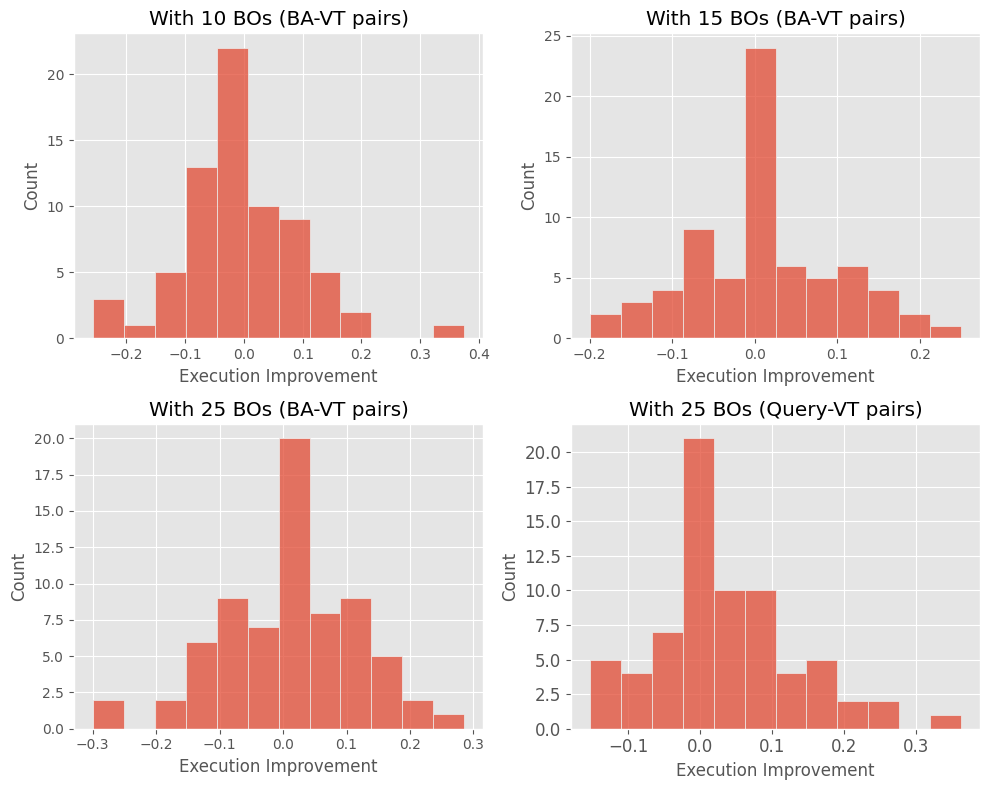

With 10 BOs (BA-VT pairs)
 - Improved 38.03(9.22) databases
 - Unimproved 61.97(-5.69) databases
With 15 BOs (BA-VT pairs)
 - Improved 36.62(10.14) databases
 - Unimproved 63.38(-4.40) databases
With 25 BOs (BA-VT pairs)
 - Improved 47.89(9.87) databases
 - Unimproved 52.11(-7.05) databases
With 25 BOs (Query-VT pairs)
 - Improved 49.30(10.95) databases
 - Unimproved 50.70(-3.88) databases


In [ ]:
merits_0 = get_merits(df_0, group_column=['db_id'])
merits_1 = get_merits(df_1, group_column=['db_id'])
merits_2 = get_merits(df_2, group_column=['db_id'])
merits_3 = get_merits(df_3, group_column=['db_id'])

# execution improvement
key = 'execution_improvement'
exps = ['With 10 BOs (BA-VT pairs)', 'With 15 BOs (BA-VT pairs)', 'With 25 BOs (BA-VT pairs)', 'With 25 BOs (Query-VT pairs)']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe().sort_values('mean', ascending=False)
    sns.histplot(df_key['mean'], bins=12, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(exps[i])
    axes[i//2, i%2].set_xlabel('Execution Improvement')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe().sort_values('mean', ascending=False)
    df_v = (df_key['mean'] > 0).value_counts()
    print(f'{exps[i]}')
    improved = df_key.loc[df_key['mean'] > 0].mean()['mean']
    unimproved = df_key.loc[df_key['mean'] <= 0].mean()['mean']
    print(f' - Improved {df_v[True] / df_v.sum()*100:.2f}({improved*100:.2f}) databases') 
    print(f' - Unimproved {df_v[False] / df_v.sum()*100:.2f}({unimproved*100:.2f}) databases') 

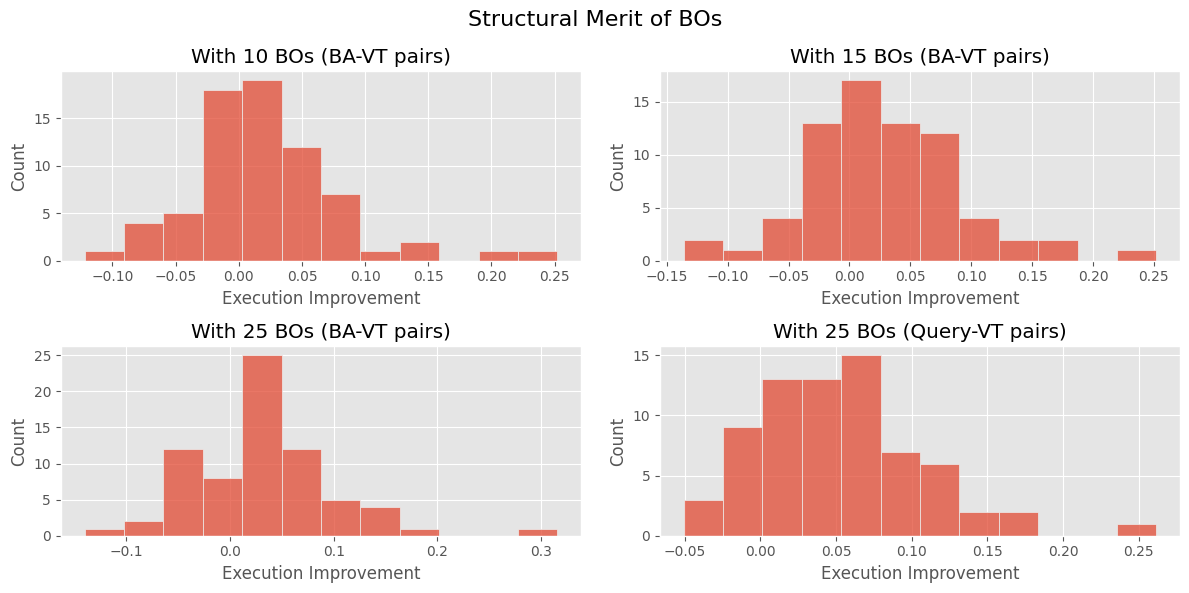

With 10 BOs (BA-VT pairs)
 - Improved 60.56(5.41) databases
 - Unimproved 39.44(-2.98) databases
With 15 BOs (BA-VT pairs)
 - Improved 67.61(6.07) databases
 - Unimproved 32.39(-3.69) databases
With 25 BOs (BA-VT pairs)
 - Improved 69.01(6.37) databases
 - Unimproved 30.99(-4.01) databases
With 25 BOs (Query-VT pairs)
 - Improved 83.10(6.76) databases
 - Unimproved 16.90(-1.43) databases


In [55]:
# structural merit
key = 'merit_structural'
exps = ['With 10 BOs (BA-VT pairs)', 'With 15 BOs (BA-VT pairs)', 'With 25 BOs (BA-VT pairs)', 'With 25 BOs (Query-VT pairs)']
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe().sort_values('mean', ascending=False)
    sns.histplot(df_key['mean'], bins=12, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(exps[i])
    axes[i//2, i%2].set_xlabel('Execution Improvement')
    
fig.suptitle('Structural Merit of BOs', fontsize=16)
plt.tight_layout()
plt.show()

for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe().sort_values('mean', ascending=False)
    df_v = (df_key['mean'] > 0).value_counts()
    print(f'{exps[i]}')
    improved = df_key.loc[df_key['mean'] > 0].mean()['mean']
    unimproved = df_key.loc[df_key['mean'] <= 0].mean()['mean']
    print(f' - Improved {df_v[True] / df_v.sum()*100:.2f}({improved*100:.2f}) databases') 
    print(f' - Unimproved {df_v[False] / df_v.sum()*100:.2f}({unimproved*100:.2f}) databases') 

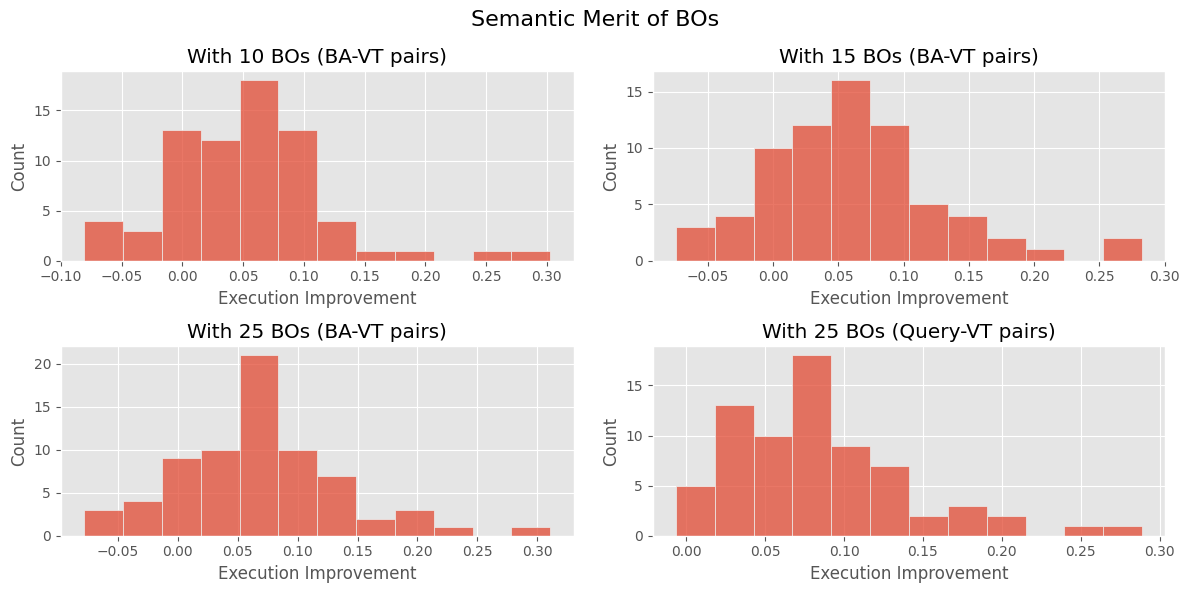

With 10 BOs (BA-VT pairs)
 - Improved 83.10(7.07) databases
 - Unimproved 16.90(-3.30) databases
With 15 BOs (BA-VT pairs)
 - Improved 83.10(7.83) databases
 - Unimproved 16.90(-2.82) databases
With 25 BOs (BA-VT pairs)
 - Improved 85.92(8.45) databases
 - Unimproved 14.08(-3.38) databases
With 25 BOs (Query-VT pairs)
 - Improved 97.18(8.75) databases
 - Unimproved 2.82(-0.37) databases


In [56]:
# merit_semantic
key = 'merit_semantic'
exps = ['With 10 BOs (BA-VT pairs)', 'With 15 BOs (BA-VT pairs)', 'With 25 BOs (BA-VT pairs)', 'With 25 BOs (Query-VT pairs)']
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe().sort_values('mean', ascending=False)
    sns.histplot(df_key['mean'], bins=12, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(exps[i])
    axes[i//2, i%2].set_xlabel('Execution Improvement')
    
fig.suptitle('Semantic Merit of BOs', fontsize=16)
plt.tight_layout()
plt.show()

for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe().sort_values('mean', ascending=False)
    df_v = (df_key['mean'] > 0).value_counts()
    print(f'{exps[i]}')
    improved = df_key.loc[df_key['mean'] > 0].mean()['mean']
    unimproved = df_key.loc[df_key['mean'] <= 0].mean()['mean']
    print(f' - Improved {df_v[True] / df_v.sum()*100:.2f}({improved*100:.2f}) databases') 
    print(f' - Unimproved {df_v[False] / df_v.sum()*100:.2f}({unimproved*100:.2f}) databases') 

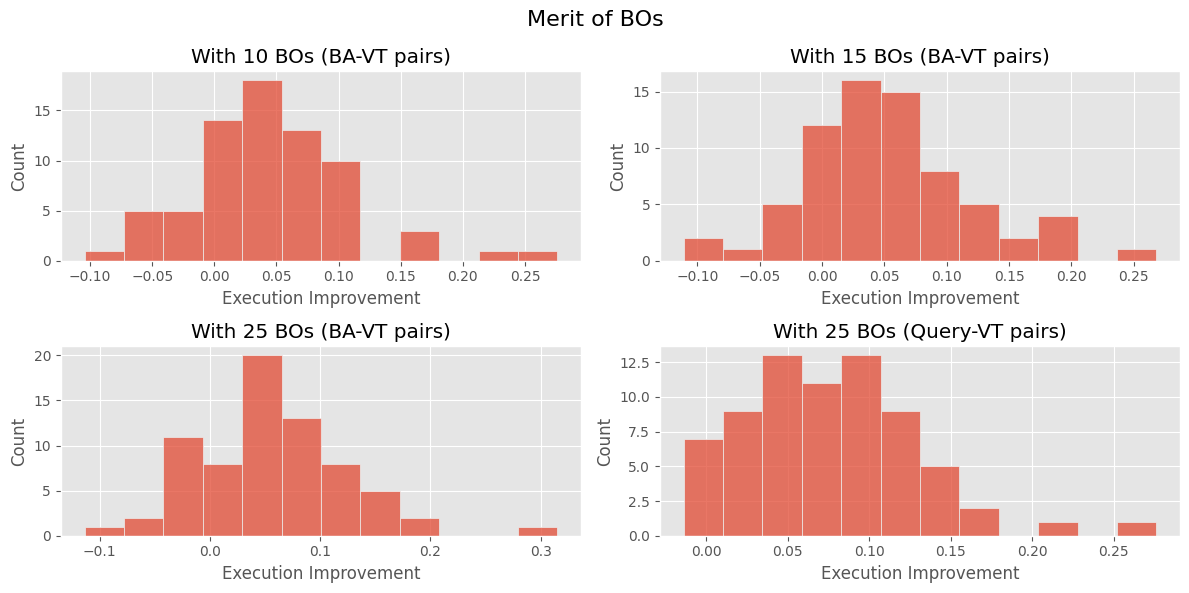

With 10 BOs (BA-VT pairs)
 - Improved 83.10(6.16) databases
 - Unimproved 16.90(-4.39) databases
With 15 BOs (BA-VT pairs)
 - Improved 76.06(7.61) databases
 - Unimproved 23.94(-2.86) databases
With 25 BOs (BA-VT pairs)
 - Improved 77.46(8.15) databases
 - Unimproved 22.54(-3.15) databases
With 25 BOs (Query-VT pairs)
 - Improved 95.77(8.09) databases
 - Unimproved 4.23(-0.69) databases


In [57]:
# merit
key = 'merit'
exps = ['With 10 BOs (BA-VT pairs)', 'With 15 BOs (BA-VT pairs)', 'With 25 BOs (BA-VT pairs)', 'With 25 BOs (Query-VT pairs)']
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe().sort_values('mean', ascending=False)
    sns.histplot(df_key['mean'], bins=12, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(exps[i])
    axes[i//2, i%2].set_xlabel('Execution Improvement')
    
fig.suptitle('Merit of BOs', fontsize=16)
plt.tight_layout()
plt.show()

for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe().sort_values('mean', ascending=False)
    df_v = (df_key['mean'] > 0).value_counts()
    print(f'{exps[i]}')
    improved = df_key.loc[df_key['mean'] > 0].mean()['mean']
    unimproved = df_key.loc[df_key['mean'] <= 0].mean()['mean']
    print(f' - Improved {df_v[True] / df_v.sum()*100:.2f}({improved*100:.2f}) databases') 
    print(f' - Unimproved {df_v[False] / df_v.sum()*100:.2f}({unimproved*100:.2f}) databases') 

In [362]:
all_dfs = []
for i, df_m in enumerate([merits_0, merits_1, merits_2, merits_3]):
    dfs = []
    key = 'execution_improvement'
    exec_impro = df_m[key].reset_index().groupby('db_id')[key].describe()['mean'].rename(f'{key}_{i}').sort_index() > 0
    dfs.append(exec_impro)
    key = 'merit_structural'
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe()['mean'].rename(f'{key}_{i}').sort_index() > 0
    dfs.append(df_key)
    key = 'merit_semantic'
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe()['mean'].rename(f'{key}_{i}').sort_index() > 0
    dfs.append(df_key)
    key = 'merit'
    df_key = df_m[key].reset_index().groupby('db_id')[key].describe()['mean'].rename(f'{key}_{i}').sort_index() > 0
    dfs.append(df_key)
    df = pd.concat(dfs, axis=1)
    all_dfs.append(df)

df = pd.concat(all_dfs, axis=1)

for i in range(4):
    df_x = df.groupby(f'merit_{i}')[f'execution_improvement_{i}'].value_counts().sort_index(ascending=False)
    print(f'{exps[i]}')
    print(df_x)
    print()


With 10 BOs (BA-VT pairs)
merit_0  execution_improvement_0
True     True                       25
         False                      34
False    True                        2
         False                      10
Name: count, dtype: int64

With 15 BOs (BA-VT pairs)
merit_1  execution_improvement_1
True     True                       23
         False                      31
False    True                        3
         False                      14
Name: count, dtype: int64

With 25 BOs (BA-VT pairs)
merit_2  execution_improvement_2
True     True                       30
         False                      25
False    True                        4
         False                      12
Name: count, dtype: int64

With 25 BOs (Query-VT pairs)
merit_3  execution_improvement_3
True     True                       34
         False                      34
False    True                        1
         False                       2
Name: count, dtype: int64



In [61]:
from scipy.stats import pearsonr

ds = 'bird'
typ = 'test'
experiment_folder = proj_path / 'experiments' / ds
eval_path = experiment_folder / 'evals' / 'zero_shot' / 'hint'

def get_data(experiment_folder, eval_path, ds, typ):
    df_base = pd.read_csv(experiment_folder / 'evals' / 'zero_shot' / f'{ds}_test.csv')
    df_0 = pd.read_csv(eval_path / f'{ds}_{typ}_0.csv')
    df_1 = pd.read_csv(eval_path / f'{ds}_{typ}_1.csv')
    df_2 = pd.read_csv(eval_path / f'{ds}_{typ}_2.csv')
    df_3 = pd.read_csv(eval_path / f'{ds}_{typ}_3.csv')
    common_ids = set(df_base['sample_id']) & set(df_0['sample_id']) & set(df_1['sample_id']) & set(df_2['sample_id']) & set(df_3['sample_id'])

    df_base = df_base[df_base['sample_id'].isin(common_ids)]
    df_cates = df_base.groupby('db_id')['gold_complexity'].apply(_get_categories_with_same_name).rename('category')
    df_base = pd.merge(df_base, df_cates.reset_index('db_id', drop=True), left_index=True, right_index=True)
    df_0 = merge(df_base, df_0[df_0['sample_id'].isin(common_ids)])
    df_1 = merge(df_base, df_1[df_1['sample_id'].isin(common_ids)])
    df_2 = merge(df_base, df_2[df_2['sample_id'].isin(common_ids)])
    df_3 = merge(df_base, df_3[df_3['sample_id'].isin(common_ids)])

    df_0['r_bool'] = df_0['retrieved'].apply(lambda x: len(eval(x))>0)
    df_1['r_bool'] = df_1['retrieved'].apply(lambda x: len(eval(x))>0)
    df_2['r_bool'] = df_2['retrieved'].apply(lambda x: len(eval(x))>0)
    df_3['r_bool'] = df_3['retrieved'].apply(lambda x: len(eval(x))>0)

    merits_0 = get_merits(df_0, group_column=['db_id'])
    merits_1 = get_merits(df_1, group_column=['db_id'])
    merits_2 = get_merits(df_2, group_column=['db_id'])
    merits_3 = get_merits(df_3, group_column=['db_id'])

    return df_base, df_0, df_1, df_2, df_3, merits_0, merits_1, merits_2, merits_3
ds = 'bird'
typ = 'test'
experiment_folder = proj_path / 'experiments' / ds
eval_path = experiment_folder / 'evals' / 'zero_shot_hint'
df_bird_base, *_ = get_data(experiment_folder, eval_path, ds, typ)

ds = 'spider'
typ = 'test'
experiment_folder = proj_path / 'experiments' / ds
eval_path = experiment_folder / 'evals' / 'zero_shot_hint'
df_spider_base, *_ = get_data(experiment_folder, eval_path, ds, typ)

In [97]:
df_bird_base.groupby('db_id')['gold_complexity'].describe()['mean'].mean()

9.449591574793397

In [98]:
df_spider_base.groupby('db_id')['gold_complexity'].describe()['mean'].mean()

8.09260515621018

In [ ]:
# gold complexity distribution per dataset 

In [71]:
palette_blue = sns.color_palette("Blues", 4).as_hex()[1:]
palette_red = sns.color_palette("Reds", 4).as_hex()[1:]
palette_green = sns.color_palette("Greens", 4).as_hex()[1:]
palette_ylbr = sns.color_palette("YlOrRd", 5).as_hex()

In [137]:
sns.color_palette("YlOrRd", 10)

[(1.0, 0.9490657439446367, 0.6754940407535563),
 (0.9982622068435217, 0.8946559015763168, 0.5544636678200692),
 (0.996078431372549, 0.8257900807381776, 0.4356170703575548),
 (0.996078431372549, 0.710634371395617, 0.31160322952710495),
 (0.9935717031910803, 0.6052902729719338, 0.25793156478277585),
 (0.9907420222991158, 0.46380622837370244, 0.20982698961937715),
 (0.980161476355248, 0.2890888119953864, 0.1601845444059977),
 (0.9063437139561706, 0.13554786620530565, 0.11884659746251441),
 (0.8072126105344098, 0.045182622068435215, 0.1316416762783545),
 (0.6745713187235679, 0.0, 0.14901960784313725)]

In [154]:
def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

df_temp1 = df_spider_base.loc[:, ['db_id', 'gold_complexity']].groupby('db_id')['gold_complexity'].mean()#.apply(min_max_normalize)#.rename(columns={'gold_complexity': 'Spider'})
df_temp1 = df_temp1.reset_index()
df_temp2 = df_bird_base.loc[:, ['db_id', 'gold_complexity']].groupby('db_id')['gold_complexity'].mean()#.apply(min_max_normalize)#.rename(columns={'gold_complexity': 'Bird'})
df_temp2 = df_temp2.reset_index()

df_temp1['Data Source'] = 'Spider'
df_temp2['Data Source'] = 'Bird'
df_combined = pd.concat([df_temp1, df_temp2])
print(df_temp1['gold_complexity'].describe()['mean'], df_temp2['gold_complexity'].describe()['mean'])

8.09260515621018 9.449591574793397


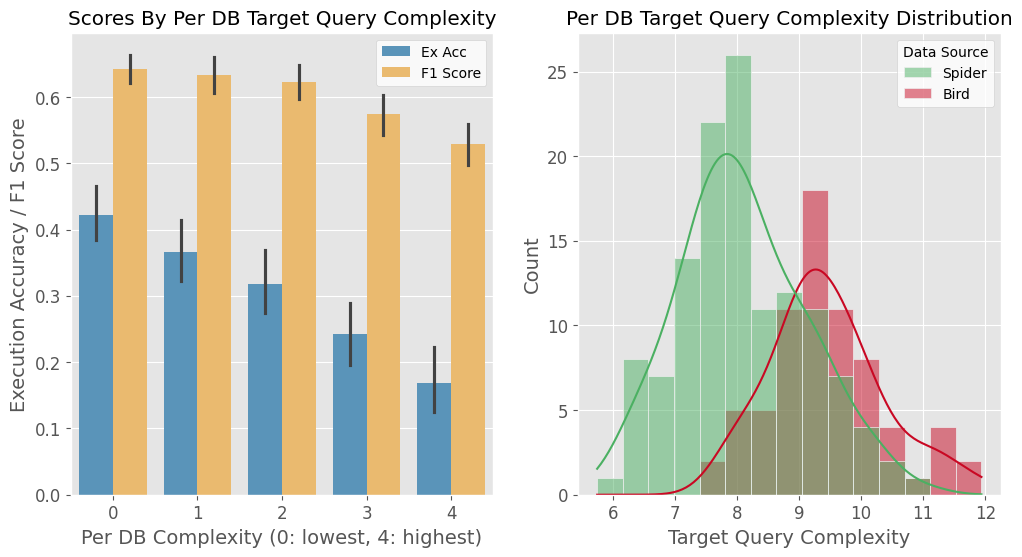

In [156]:
palette_blue = sns.color_palette("Blues", 4).as_hex()[1:]
palette_red = sns.color_palette("Reds", 4).as_hex()[1:]
palette_green = sns.color_palette("Greens", 4).as_hex()[1:]
palette_ylbr = sns.color_palette("YlOrRd", 5).as_hex()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
ax1 = axes[0]
ax2 = axes[1]
df = df_base.loc[:, ['exec_result', 'category', 'f1_score']]
tidy = df.melt(id_vars='category').rename(columns=str.title).sort_values('Category')
sns.barplot(x='Category', y='Value', hue='Variable', data=tidy, ax=ax1, palette=[palette_blue[1], palette_ylbr[1]])
ax1.set_xlabel('Per DB Complexity (0: lowest, 4: highest)', fontsize=14)
ax1.set_ylabel('Execution Accuracy / F1 Score', fontsize=14)
ax1.set_title('Scores By Per DB Target Query Complexity')
ax1.tick_params(axis='both', which='major', labelsize=12)
handles, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(handles=handles, labels=['Ex Acc', 'F1 Score'], title=None)
frame = legend.get_frame()
frame.set_facecolor('white')

plot2 = sns.histplot(data=df_combined, x='gold_complexity', hue='Data Source', kde=True, bins=15, palette=[palette_green[1], palette_ylbr[-1]], alpha=0.5, legend=True, ax=ax2)
ax2.set_title('Per DB Target Query Complexity Distribution')
ax2.set_xlabel('Target Query Complexity', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
# handles, labels = ax2.get_legend_handles_labels()
# legend = ax2.legend(handles=handles[1:], labels=['Spider', 'Bird'], title=None)
legend = plot2.get_legend()
frame = legend.get_frame()
frame.set_facecolor('white')
# df = df_base.loc[:, ['db_id', 'category', 'f1_score', 'exec_result']]
# df_corr = df.groupby('db_id')[['f1_score', 'exec_result']].corr().unstack()['exec_result']['f1_score']
# df_corr.rename('Pearson Correlation', inplace=True)
# sns.histplot(df_corr, bins=10, ax=ax2, binwidth=0.10, kde=True, color=sns.color_palette("Spectral", 6).as_hex()[5])
# ax2.set_title('Per DB Corr(Ex Acc and F1 Score) Distribution')
# ax2.set_xlabel('Pearson Correlation', fontsize=14)
# ax2.set_ylabel('Count', fontsize=14)
# ax2.tick_params(axis='both', which='major', labelsize=12)

# Ex acc and F1 score: F1 Score를 metric으로 쓸 수 있을까?

In [157]:
fig.savefig(proj_path / 'Scores_Dist.pdf', bbox_inches='tight', dpi='figure', pad_inches=0.05)

In [152]:
plot2.get_legend()

<Axes: xlabel='db_id'>

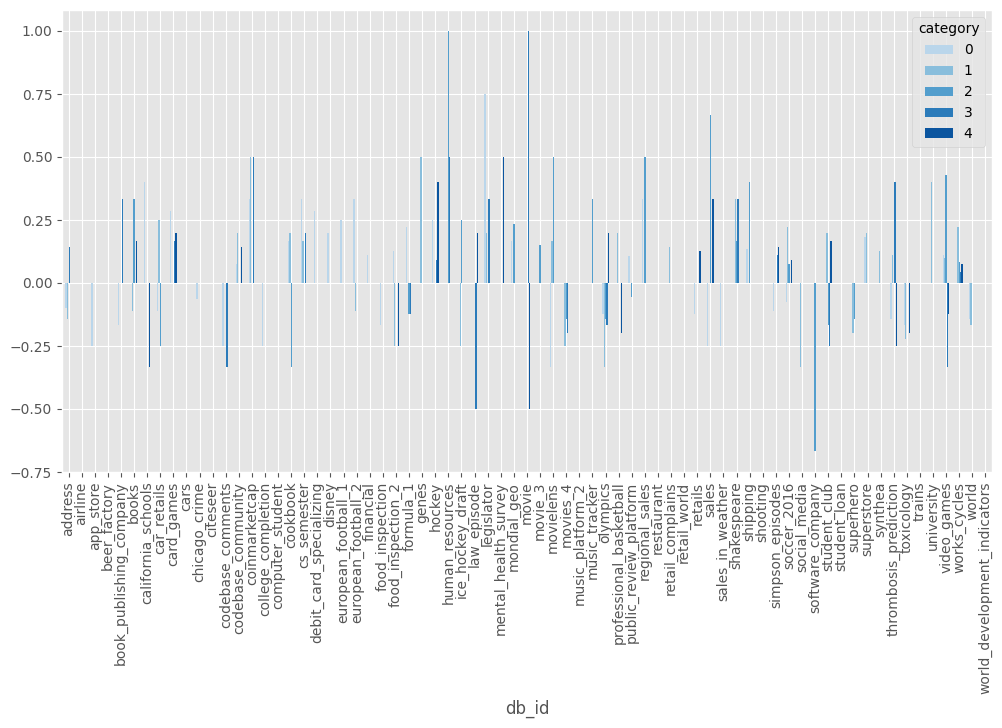

In [ ]:
# complexity 별로 도움이 된 케이스
merits_3['execution_improvement'].reset_index().groupby(['db_id', 'category'])['execution_improvement'].mean().unstack().plot(kind='bar', figsize=(12, 6), color=sns.color_palette("Blues", 6).as_hex()[1:])

In [429]:
df_cate_improve = merits_3['execution_improvement'].reset_index().groupby(['db_id', 'category'])['execution_improvement'].mean().reset_index()
df_cate_merit = merits_3['merit'].reset_index().groupby(['db_id', 'category'])['merit'].mean().reset_index()

In [456]:
df_cate_improve = merits_2['execution_improvement'].reset_index().groupby(['db_id', 'category'])['execution_improvement'].mean().reset_index()
df_cate_merit = merits_2['merit'].reset_index().groupby(['db_id', 'category'])['merit'].mean().reset_index()

In [ ]:
df = df_base.loc[:, ['exec_result', 'category', 'f1_score']]
tidy = df.melt(id_vars='category').rename(columns=str.title).sort_values('Category')

<Axes: xlabel='category', ylabel='execution_improvement'>

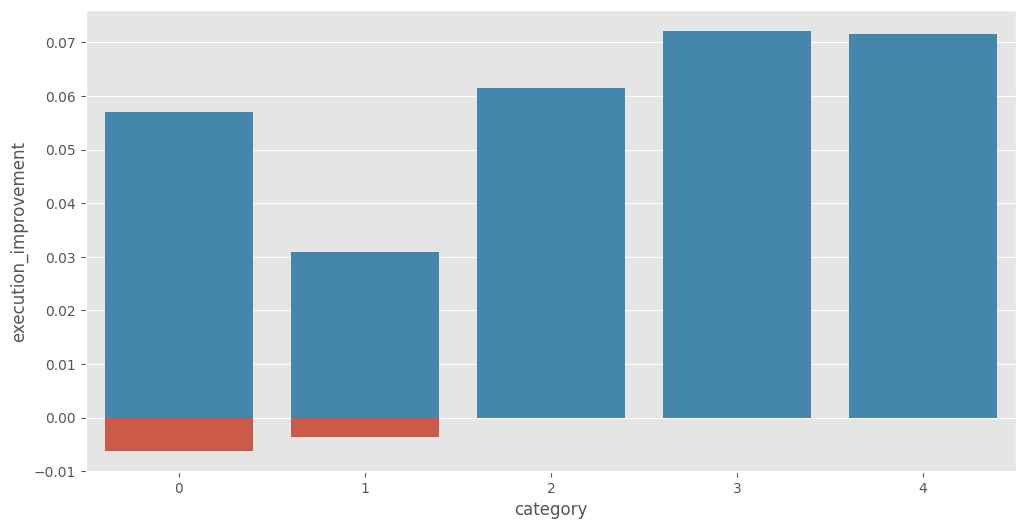

In [457]:
fig, ax = plt.subplots(figsize=(12, 6))
label = 'Execution Improvement'
sns.barplot(data=df_cate_improve.groupby('category')['execution_improvement'].mean(), ax=ax, legend=True)
sns.barplot(data=df_cate_merit.groupby('category')['merit'].mean(), ax=ax, legend=True)
# ax.axvline(df_cate_improve['execution_improvement'].mean(), color='r', linestyle='--')

In [ ]:
# complexity vs execution accuracy

fig , ax = plt.subplots(1, 1, figsize=(12, 6))

coor_base_ex = pearsonr(df_base['exec_result'], df_base['category_2'])
coor_base_f1 = pearsonr(df_base['f1_score'], df_base['category_2'])

In [240]:
import numpy as np
import scipy.stats as st

def mean_confidence_interval(data, confidence=0.95):
    m1 = data['f1_q'].mean()
    a1, b1 = st.t.interval(confidence, len(data['f1_q'])-1, loc=np.mean(data['f1_q']), scale=st.sem(data['f1_q']))

    m2 = data['f1_ba'].mean()
    a2, b2 = st.t.interval(confidence, len(data['f1_ba'])-1, loc=np.mean(data['f1_ba']), scale=st.sem(data['f1_ba']))
    return (m1, a1, b1), (m2, a2, b2)

df_sim = pd.read_csv(experiment_folder / 'question_ba_similarity.csv')
df_sim = pd.merge(df_2.loc[:, ['db_id', 'sample_id', 'exec_result_bo']], 
         df_sim, on=['db_id', 'sample_id']).rename(columns={'exec_result_bo': 'ex_bo_2'})
df_sim = pd.merge(df_3.loc[:, ['db_id', 'sample_id', 'exec_result_bo']], 
         df_sim, on=['db_id', 'sample_id']).rename(columns={'exec_result_bo': 'ex_bo_3'})
df_sim

,db_id,sample_id,ex_bo_3,ex_bo_2,bo_id,f1_q,f1_ba
0,student_club,10836,1,0,10741,0.050348,0.045856
1,student_club,10836,1,0,10830,0.132332,0.005537
2,student_club,10836,1,0,10857,0.052833,-0.044861
3,student_club,10836,1,0,10775,0.169878,-0.043961
4,student_club,10836,1,0,10761,0.224581,-0.062759
...,...,...,...,...,...,...,...
18065,beer_factory,5274,0,0,5315,0.099307,-0.096740
18066,beer_factory,5274,0,0,5288,0.117597,0.051366
18067,beer_factory,5274,0,0,5253,0.064000,-0.085368
18068,beer_factory,5274,0,0,5275,0.208279,0.051613


In [245]:
df_sim_desc = df_sim.groupby('db_id')[['f1_q', 'f1_ba']].describe()
df_sim_desc.mean(axis=0)

f1_q   count    254.507042
       mean       0.177953
       std        0.126992
       min       -0.127974
       25%        0.092124
       50%        0.170010
       75%        0.251858
       max        0.629281
f1_ba  count    254.507042
       mean       0.009390
       std        0.078942
       min       -0.198458
       25%       -0.043430
       50%        0.011224
       75%        0.061876
       max        0.219732
dtype: float64

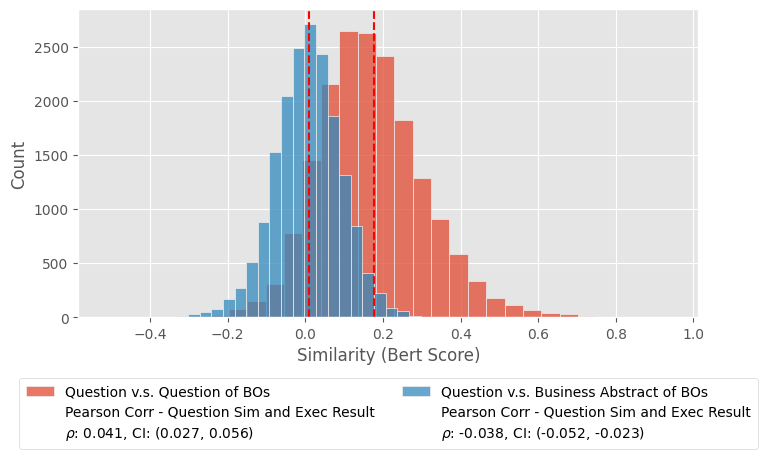

In [489]:
from scipy.stats import pearsonr

fig , ax = plt.subplots(1, 1, figsize=(8,4), dpi=100)

coor_ba = pearsonr(df_sim['f1_ba'], df_sim['ex_bo_2'])
coor_q = pearsonr(df_sim['f1_q'], df_sim['ex_bo_3'])
s_labels = [
    f'Question v.s. Question of BOs',
    f'Question v.s. Business Abstract of BOs'
]
for k, label, coor in zip(['f1_q', 'f1_ba'], s_labels, [coor_q, coor_ba]):
    sns.histplot(data=df_sim, x=k, bins=30, ax=ax, kde=False, label=label, legend=True)
    ax.axvline(df_sim_desc[k]['mean'].mean(), color='r', linestyle='--')
    ax.plot([], [], ' ', label=f'Pearson Corr - Question Sim and Exec Result')
    low, high = coor.confidence_interval(0.95)
    ax.plot([], [], ' ', label=f'$\\rho$: {coor.statistic:.3f}, CI: ({low:.3f}, {high:.3f})')
    ax.set_xlabel('Similarity (Bert Score)')

# Adding legend
handles, labels = fig.gca().get_legend_handles_labels()
order = [4, 0, 1, 5, 2, 3]
new_handles = [handles[i] for i in order]
new_labels = [labels[i] for i in order]

legend = plt.legend(
    handles=new_handles,
    labels=new_labels,
    loc='lower center',  # Position the legend at the bottom
    bbox_to_anchor=(0.5, -0.45),  # Center outside the plot
    frameon=True,
    borderpad=0.5,
    labelspacing=0.4,
    ncol=2  # Two columns
)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

In [490]:
fig.savefig(proj_path / 'QuestionSim.pdf', bbox_inches='tight', dpi='figure', pad_inches=0.05)

In [278]:
labels

['Pearson Corr - Question Sim and Exec Result',
 '$\\rho$: 0.041, CI: (0.027, 0.056)',
 '$\\rho$: -0.038, CI: (-0.052, -0.023)',
 'Question v.s. Question of BOs',
 'Question v.s. Business Abstract of BOs']

In [276]:
3,0,1,4,0,2

['Question v.s. Question of BOs', 'Question v.s. Business Abstract of BOs']

In [93]:
# df_sim.groupby('db_id')[['f1_q', 'f1_ba']].apply(mean_confidence_interval)['address']
df_sim_avg = df_sim.groupby('db_id')[['f1_q', 'f1_ba']].mean()

for k in ['f1_q', 'f1_ba']:
    print(f'{k} - {df_sim_avg[k].mean():.4f} +/- {df_sim_avg[k].sem():.4f}')
print()
print(f'Question - VT pairs')
print((df_sim_avg > 0)['f1_q'].value_counts())
print(f'BA - VT pairs')
print((df_sim_avg > 0)['f1_ba'].value_counts())

f1_q - 0.1780 +/- 0.0064
f1_ba - 0.0094 +/- 0.0037

Question - VT pairs
f1_q
True    71
Name: count, dtype: int64
BA - VT pairs
f1_ba
True     45
False    26
Name: count, dtype: int64


In [121]:
df_sim_avg

,f1_q,f1_ba,f1_q_ex,f1_ba_ex
db_id,,,,
address,0.146988,-0.024995,-0.033333,0.033333
airline,0.153569,0.010390,0.000000,0.071429
app_store,0.179990,0.028675,-0.083333,-0.083333
beer_factory,0.177776,0.006178,0.000000,-0.037037
book_publishing_company,0.109937,0.010967,0.000000,0.000000
...,...,...,...,...
university,0.223519,0.001860,0.066667,0.066667
video_games,0.226600,0.015861,0.050000,-0.100000
works_cycles,0.098299,-0.023945,0.076923,0.054945


In [471]:
len(df_base)

1807

In [ ]:
df_sim_avg['f1_q'].corr(df_sim_avg['f1_q_ex']), df_sim_avg['f1_ba'].corr(df_sim_avg['f1_ba_ex'])

(-0.017739098276310903, -0.03307758068778274)

In [47]:
# # question similarity
# scenario = 0
# bo_path = experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json'
# with bo_path.open() as f:
#     all_bos = json.load(f)
# sce = {0: "10", 1: "15", 2: "25", 3: "25"}[scenario]

# # test_scenarios
# with (experiment_folder / 'test_scenarios.json').open('r') as f:
#     test_scenarios = json.load(f)

# test_bo_ids = test_scenarios[sce]
# test_bos = defaultdict(list)
# for db_id, bos in all_bos.items():
#     if db_id in test_bo_ids:
#         bo_ids = test_bo_ids[db_id]
#         test_bos[db_id].extend(list(filter(lambda x: x['sample_id'] in bo_ids, bos)))

# # question similarity
# q_pairs = defaultdict(list)
# ba_pairs = defaultdict(list)
# for test_sample in test_samples:
#     for bo in test_bos[test_sample.db_id]:
#         q_pairs[test_sample.db_id].append((test_sample.final.question, bo['question']))
#         ba_pairs[test_sample.db_id].append((test_sample.final.question, bo['ba']))

# scores = {}
# iterator = tqdm(q_pairs, total=len(q_pairs))
# for db_id in iterator:
#     qs, qt = zip(*q_pairs[db_id])
#     bas, bat = zip(*ba_pairs[db_id])
#     with warnings.catch_warnings(action='ignore'):
#         iterator.set_description(f'{db_id} - q')
#         *_, f1_q = bscore(qs, qt, lang='en', rescale_with_baseline=True, device='cuda')
#         iterator.set_description(f'{db_id} - ba')
#         *_, f1_ba = bscore(bas, bat, lang='en', rescale_with_baseline=True, device='cuda')
#     scores[db_id] = (f1_q.numpy().mean(), f1_ba.numpy().mean())

# with open(experiment_folder / 'question_ba_similarity.pkl', 'wb') as f:
#     pickle.dump(scores, f)

In [30]:
ds = 'spider'
experiment_folder = proj_path / 'experiments' / ds
bo_path = experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json'
with bo_path.open() as f:
    all_bos = json.load(f)

* train: 
* dev: 2050 | 25.949 | 15.34

In [31]:
df = pd.read_csv(experiment_folder / 'evals' / 'zero_shot' / f'{ds}_dev.csv')
df_base = pd.read_csv(experiment_folder / 'evals' / 'zero_shot' / f'{ds}_test.csv')

In [32]:
df_base.groupby('db_id')['f1_score'].mean().describe()
df_base.groupby('db_id')['exec_result'].mean().describe()

count    158.000000
mean       0.780279
std        0.100687
min        0.526975
25%        0.716210
50%        0.769545
75%        0.844040
max        1.000000
Name: f1_score, dtype: float64

In [34]:
df_base.groupby('db_id')['exec_result'].mean().describe()

count    158.000000
mean       0.755729
std        0.188418
min        0.235294
25%        0.627841
50%        0.769231
75%        0.888889
max        1.000000
Name: exec_result, dtype: float64

In [24]:
df_temp = df_base.groupby('db_id')['exec_result'].mean()
df_temp

db_id
activity_1           0.526316
aircraft             0.800000
allergy_1            0.666667
apartment_rentals    0.750000
architecture         1.000000
                       ...   
wine_1               0.588235
workshop_paper       0.666667
world_1              0.541667
wrestler             0.625000
wta_1                0.769231
Name: exec_result, Length: 158, dtype: float64

In [19]:
df_base.groupby('db_id')['exec_result'].mean().loc[df_base.groupby('db_id')['exec_result'].mean()['mean'] > 0].describe()

KeyError: 'mean'

In [15]:
df_base['exec_result'].mean(), df_base['exec_result'].std()

(0.33270940570893776, 0.47129374718258393)

In [499]:
df.groupby('db_id')['sample_id'].size().mean(), df.groupby('db_id')['sample_id'].size().std(), len(df)

(9.835443037974683, 6.241285143968909, 1554)

In [501]:
df_base.groupby('db_id')['sample_id'].size().mean(), df_base.groupby('db_id')['sample_id'].size().std(), len(df_base)

(10.759493670886076, 6.354125376173973, 1700)

In [502]:
bo_path = experiment_folder / 'predictions' / 'create_bo' / f'final_{ds}_train_bo.json'
with bo_path.open() as f:
    bos = json.load(f)

ns = []
for _, bo in bos.items():
    ns.append(len(bo))

In [503]:
np.mean(ns), np.std(ns), np.sum(ns)

(30.126582278481013, 18.751112769415354, 4760)